<a href="https://colab.research.google.com/github/mcurry572/4540/blob/main/XOR_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

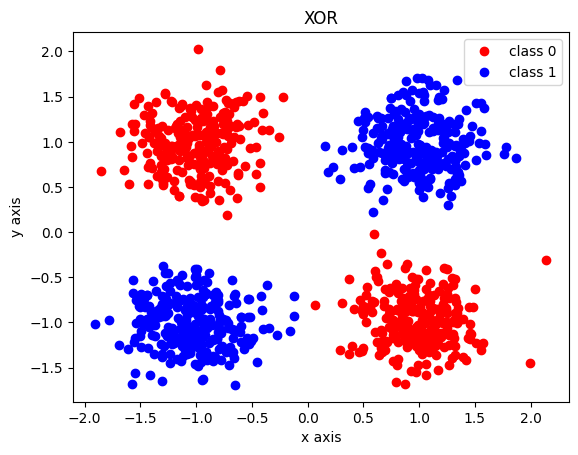

In [55]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)
X = rng.randn(1000, 2)
X = (X > 0) * 2 - 1 + 0.3 * rng.randn(*X.shape)
Y = np.logical_xor(X[:,0] > 0, X[:,1] > 0).astype(int)

c0 = X[np.nonzero(Y)[0]]
c1 = X[np.nonzero(Y == 0)[0]]

plt.plot(c0[:,0], c0[:,1], 'ro', label='class 0')
plt.plot(c1[:,0], c1[:,1], 'bo', label='class 1')

plt.title('XOR')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.legend()
plt.show()


In [56]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

batch_size=8

training_data = DataLoader(TensorDataset(torch.Tensor(X[:750,:]), torch.tensor(Y[:750], dtype=torch.long)), shuffle=True, batch_size=batch_size)
validation_data = DataLoader(TensorDataset(torch.Tensor(X[750:,:]), torch.tensor(Y[750:], dtype=torch.long)), batch_size=batch_size)

In [57]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.activation = nn.ReLU()
        self.first_hidden = nn.Linear(2, 10)
        #self.second_hidden = nn.Linear(10, 5)
        self.output = nn.Linear(10, 2)

    def forward(self, x):
        x = self.activation(self.first_hidden(x))
        #x = self.activation(self.second_hidden(x))
        x = self.output(x)
        return x

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (activation): ReLU()
  (first_hidden): Linear(in_features=2, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=2, bias=True)
)


In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)

In [59]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [60]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [61]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_data, model, loss_fn, optimizer)
    test(validation_data, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.797230  [    0/  750]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.426721 

Epoch 2
-------------------------------
loss: 0.456449  [    0/  750]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.210375 

Epoch 3
-------------------------------
loss: 0.239465  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.117287 

Epoch 4
-------------------------------
loss: 0.152413  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.078297 

Epoch 5
-------------------------------
loss: 0.047187  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.058256 

Epoch 6
-------------------------------
loss: 0.055442  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.046007 

Epoch 7
-------------------------------
loss: 0.038043  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.037977 

Epoch 8
-------------------------------
loss: 0.092495  [    0/  750]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.032518 

Epoch 9
----------------

In [62]:
def predict(x):
    #Convert into numpy element to tensor
    x = torch.from_numpy(x).type(torch.FloatTensor).to(device)
    #Predict and return ans
    ans = torch.argmax(model(x), dim=1)
    return ans.to('cpu').detach().numpy()

In [63]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func,X,Y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.title('XOR')
    plt.xlabel('x axis')
    plt.ylabel('y axis')
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    # Plot ground truth
    c0 = X[np.nonzero(Y)[0]]
    c1 = X[np.nonzero(Y == 0)[0]]
    plt.plot(c0[:,0], c0[:,1], 'ko', label='class 0')
    plt.plot(c1[:,0], c1[:,1], 'wo', label='class 1')
    plt.legend()

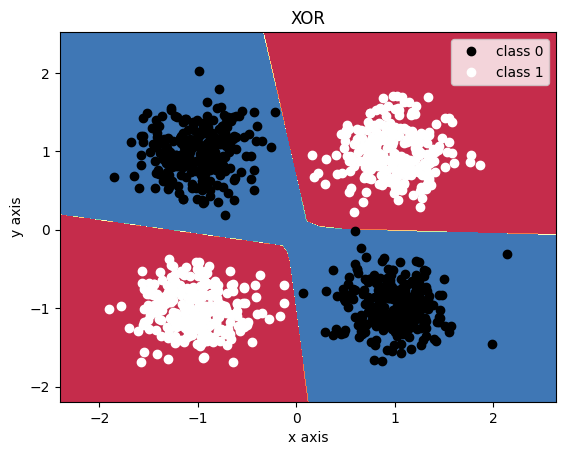

In [64]:
plot_decision_boundary(predict, X, Y)

In [67]:
# uses data above to solve the XOR problem


import numpy as np

# making sigmoid function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

#three instances of perception
def xor_perceptron(x):
    # Perceptron 1
    w1_1 = 1
    w1_2 = 1
    b1 = -0.5
    p1 = sigmoid(w1_1 * x[0] + w1_2 * x[1] + b1)

    # Perceptron 2
    w2_1 = -1
    w2_2 = -1
    b2 = 0.5
    p2 = sigmoid(w2_1* x[0] + w2_2 * x[1] +b2)

    # Perceptron 3
    w3_1 = 2
    w3_2 = 1
    b3 = -0.5

    p3 = sigmoid(w3_1 * p1 + w3_2 * p2 + b3)
    return 1 if p3 >= 0.5 else 0

# printing my outputs
for x in X:
    print(f"Input: {x}, Output: {xor_perceptron(x)}")


Input: [0.54012368 0.48640895], Output: 1
Input: [1.01384052 0.71248766], Output: 1
Input: [ 0.97575652 -1.21115771], Output: 1
Input: [ 0.76876471 -1.1442536 ], Output: 1
Input: [-0.78892433  1.27874354], Output: 1
Input: [1.11135177 0.70305324], Output: 1
Input: [1.19308938 1.206669  ], Output: 1
Input: [1.08239416 0.81891387], Output: 1
Input: [ 1.21265787 -0.87315443], Output: 1
Input: [ 0.06494302 -0.80666439], Output: 1
Input: [-1.5741228   1.19906847], Output: 1
Input: [ 0.95377828 -0.6419165 ], Output: 1
Input: [ 0.97055164 -1.26598428], Output: 1
Input: [ 0.9557939  -0.68205811], Output: 1
Input: [1.00787399 0.96569945], Output: 1
Input: [1.22306605 1.06310781], Output: 1
Input: [-1.00177822 -0.59018198], Output: 1
Input: [-0.53346579  1.18399787], Output: 1
Input: [0.91421225 1.4490733 ], Output: 1
Input: [-0.64506413 -0.78433085], Output: 1
Input: [-1.36482297 -0.95779843], Output: 1
Input: [-1.22310165  0.95229632], Output: 1
Input: [-0.92798292 -0.96995218], Output: 1
Inpu